In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.src.datasets import cifar10
from keras.api.models import Sequential
from keras.api.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Input
from keras.api.optimizers import Adam
from keras.api.losses import SparseCategoricalCrossentropy
from sklearn.metrics import f1_score

(x_full_train, y_full_train), (x_test, y_test) = cifar10.load_data()
x_full_train = x_full_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
split_index = int(0.8 * len(x_full_train))
x_train, x_val = x_full_train[:split_index], x_full_train[split_index:]
y_train, y_val = y_full_train[:split_index], y_full_train[split_index:]

--- Eksperimen: conv2 ---
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3695 - loss: 1.7371 - val_accuracy: 0.5905 - val_loss: 1.1515
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6166 - loss: 1.0819 - val_accuracy: 0.6359 - val_loss: 1.0512
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6911 - loss: 0.8748 - val_accuracy: 0.6796 - val_loss: 0.9145
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7438 - loss: 0.7290 - val_accuracy: 0.7021 - val_loss: 0.8779
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7969 - loss: 0.5724 - val_accuracy: 0.7016 - val_loss: 0.9083
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8445 - loss: 0.4390 - val_accuracy: 0.7190 - val_loss: 0.9241
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8899 - loss: 0.3187 - val_accuracy: 0.7116 - val_loss: 1.0127
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9247 - loss

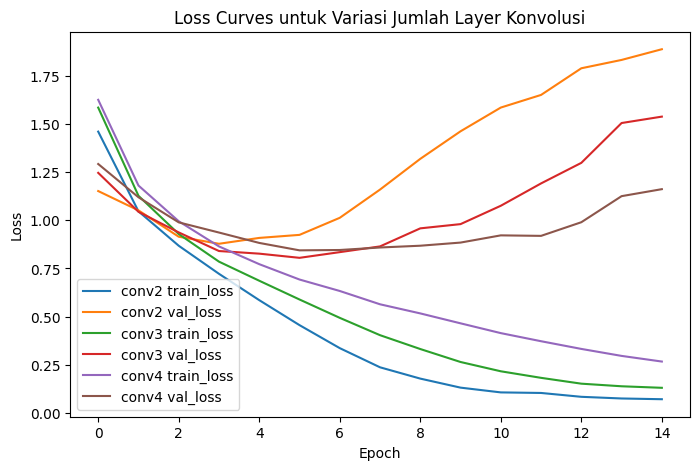

,Macro F1-score
conv3,0.7077
conv4,0.7021
conv2,0.6975


In [ ]:
def build_cnn_model(num_conv_layers, filters_per_layer, kernel_sizes, pooling_type='max'):
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    for i in range(num_conv_layers):
        model.add(Conv2D(filters=filters_per_layer[i], kernel_size=kernel_sizes[i],
                         activation='relu', padding='same'))
        if pooling_type == 'max':
            model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        else:
            model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(20, activation='softmax'))
    model.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

def plot_loss_curves(hist_dict, title):
    plt.figure(figsize=(8,5))
    for name, hist in hist_dict.items():
        plt.plot(hist['loss'], label=f"{name} train_loss")
        plt.plot(hist['val_loss'], label=f"{name} val_loss")
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def show_f1_table(score_dict, title):
    df = pd.DataFrame.from_dict(score_dict, orient='index', columns=["Macro F1-score"])
    df = df.sort_values(by="Macro F1-score", ascending=False)
    display(
        df.style
          .format({"Macro F1-score": "{:.4f}"})
          .set_caption(title)
    )

experiments = [
    {'name':'conv2', 'num_conv_layers':2, 'filters_per_layer':[64,64], 'kernel_sizes':[3,3], 'pooling_type':'max'},
    {'name':'conv3', 'num_conv_layers':3, 'filters_per_layer':[64,64,64], 'kernel_sizes':[3,3,3], 'pooling_type':'max'},
    {'name':'conv4', 'num_conv_layers':4, 'filters_per_layer':[64,64,64,64], 'kernel_sizes':[3,3,3,3], 'pooling_type':'max'},
]

histories = {}
f1_scores = {}

def run_experiments(experiments, epochs=20, batch_size=64):
    results = {}
    for cfg in experiments:
        print(f"--- Eksperimen: {cfg['name']} ---")
        model = build_cnn_model(
          cfg['num_conv_layers'],
          cfg['filters_per_layer'],
          cfg['kernel_sizes'],
          cfg['pooling_type']
        )

        history = model.fit(
            x_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            verbose=1
        )
        histories[cfg['name']] = history.history
        y_pred = np.argmax(model.predict(x_test), axis=1)
        y_true = y_test.flatten()
        f1 = f1_score(y_true, y_pred, average='macro')
        f1_scores[cfg['name']] = f1
        print(f"Macro F1-score (test) for {cfg['name']}: {f1:.4f}\n")
    return results


results = run_experiments(experiments, epochs=15, batch_size=64)

plot_loss_curves(histories, 'Loss Curves untuk Variasi Jumlah Layer Konvolusi')
show_f1_table(f1_scores, 'F1-score Akhir untuk Variasi Jumlah Layer Konvolusi')

--- Eksperimen: filter_32-64-128 ---
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3360 - loss: 1.8136 - val_accuracy: 0.5635 - val_loss: 1.2029
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6032 - loss: 1.1056 - val_accuracy: 0.6331 - val_loss: 1.0379
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6943 - loss: 0.8620 - val_accuracy: 0.7065 - val_loss: 0.8471
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7477 - loss: 0.7132 - val_accuracy: 0.7216 - val_loss: 0.8092
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7957 - loss: 0.5914 - val_accuracy: 0.7227 - val_loss: 0.8487
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8230 - loss: 0.4972 - val_accuracy: 0.7368 - val_loss: 0.8024
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8670 - loss: 0.3845 - val_accuracy: 0.7454 - val_loss: 0.8006
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9

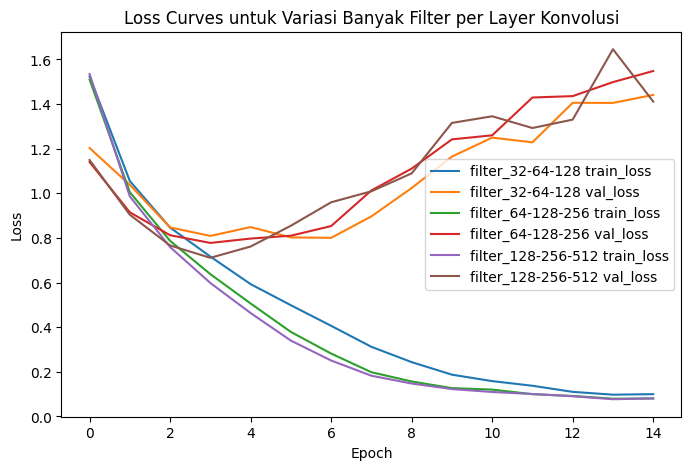

,Macro F1-score
filter_128-256-512,0.7473
filter_32-64-128,0.7244
filter_64-128-256,0.7192


In [3]:
histories = {}
f1_scores = {}
experiments = [
    {'name':'filter_32-64-128','num_conv_layers':3,'filters_per_layer':[32,64,128], 'kernel_sizes':[3,3,3],'pooling_type':'max'},
    {'name':'filter_64-128-256','num_conv_layers':3,'filters_per_layer':[64,128,256], 'kernel_sizes':[3,3,3],'pooling_type':'max'},
    {'name':'filter_128-256-512','num_conv_layers':3,'filters_per_layer':[128,256,512],'kernel_sizes':[3,3,3],'pooling_type':'max'}
]

results = run_experiments(experiments, epochs=15, batch_size=64)
plot_loss_curves(histories, 'Loss Curves untuk Variasi Banyak Filter per Layer Konvolusi')
show_f1_table(f1_scores, 'F1-score Akhir untuk Variasi Banyak Filter per Layer Konvolusi')

--- Eksperimen: kernel_2 ---
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3355 - loss: 1.8140 - val_accuracy: 0.5743 - val_loss: 1.1910
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5907 - loss: 1.1402 - val_accuracy: 0.6236 - val_loss: 1.0435
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6611 - loss: 0.9503 - val_accuracy: 0.6393 - val_loss: 1.0218
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7059 - loss: 0.8292 - val_accuracy: 0.7003 - val_loss: 0.8660
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7493 - loss: 0.7086 - val_accuracy: 0.7119 - val_loss: 0.8353
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7918 - loss: 0.5870 - val_accuracy: 0.7113 - val_loss: 0.8449
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8203 - loss: 0.5072 - val_accuracy: 0.7292 - val_loss: 0.8288
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8544 - lo

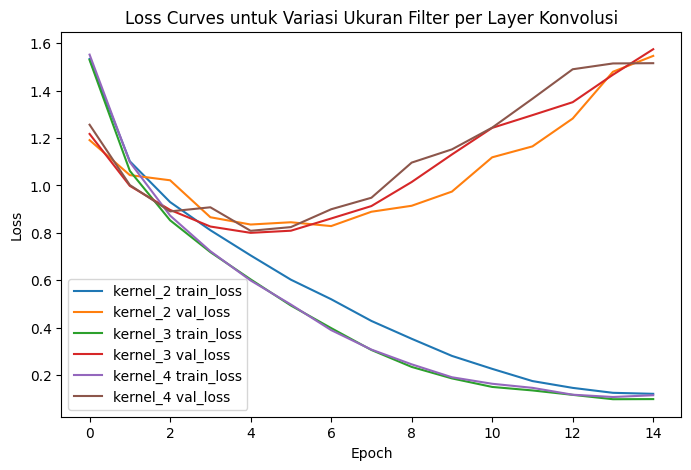

,Macro F1-score
kernel_3,0.7161
kernel_4,0.7062
kernel_2,0.7005


In [4]:
histories = {}
f1_scores = {}
experiments = [
    {'name':'kernel_2','num_conv_layers':3,'filters_per_layer':[32,64,128],'kernel_sizes':[2,2,2],'pooling_type':'max'},
    {'name':'kernel_3','num_conv_layers':3,'filters_per_layer':[32,64,128],'kernel_sizes':[3,3,3],'pooling_type':'max'},
    {'name':'kernel_4','num_conv_layers':3,'filters_per_layer':[32,64,128],'kernel_sizes':[4,4,4],'pooling_type':'max'},
]

results = run_experiments(experiments, epochs=15, batch_size=64)
plot_loss_curves(histories, 'Loss Curves untuk Variasi Ukuran Filter per Layer Konvolusi')
show_f1_table(f1_scores, 'F1-score Akhir untuk Variasi Ukuran Filter per Layer Konvolusi')

--- Eksperimen: pool_max ---
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3297 - loss: 1.8187 - val_accuracy: 0.5427 - val_loss: 1.2689
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5840 - loss: 1.1603 - val_accuracy: 0.6407 - val_loss: 1.0201
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6657 - loss: 0.9325 - val_accuracy: 0.6965 - val_loss: 0.8795
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7381 - loss: 0.7497 - val_accuracy: 0.7207 - val_loss: 0.8094
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7796 - loss: 0.6228 - val_accuracy: 0.7410 - val_loss: 0.7691
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8128 - loss: 0.5236 - val_accuracy: 0.7343 - val_loss: 0.8085
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8545 - loss: 0.4162 - val_accuracy: 0.7444 - val_loss: 0.8150
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8905 - lo

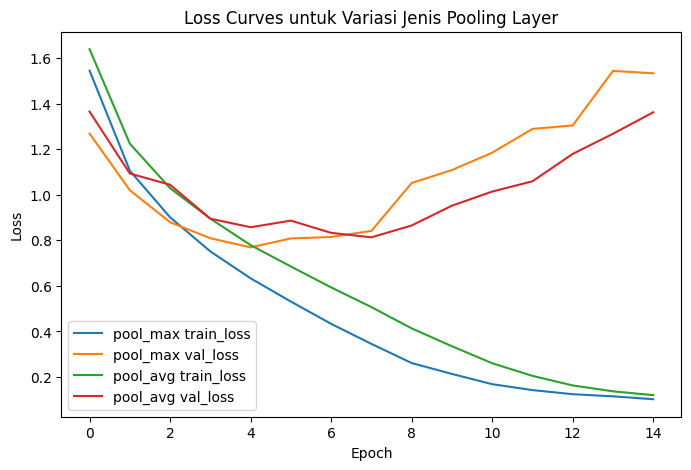

,Macro F1-score
pool_max,0.7318
pool_avg,0.7187


In [5]:
histories = {}
f1_scores = {}
experiments = [
    {'name':'pool_max','num_conv_layers':3,'filters_per_layer':[32,64,128],'kernel_sizes':[3,3,3],'pooling_type':'max'},
    {'name':'pool_avg','num_conv_layers':3,'filters_per_layer':[32,64,128],'kernel_sizes':[3,3,3],'pooling_type':'average'}
]

results = run_experiments(experiments, epochs=15, batch_size=64)
plot_loss_curves(histories, 'Loss Curves untuk Variasi Jenis Pooling Layer')
show_f1_table(f1_scores, 'F1-score Akhir untuk Variasi Jenis Pooling Layer')